<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_Succ_Complete_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Prep

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip/
!cp ../kaggle.json /root/.kaggle/

/content/gdrive/MyDrive/Kaggle/unzip
cp: cannot create regular file '/root/.kaggle/': Not a directory


GitHub

In [8]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(3407)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [11]:
path = "/content/gdrive/MyDrive/Kaggle/unzip/"

all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split

# subset
# sub_df, depre_df = train_test_split(all_df, test_size=0.9, random_state=42)

# Assuming train_df is your original training DataFrame
train_df, test_df = train_test_split(all_df, test_size=7000, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)


print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 25313
No.of.testing_samples: 7000
No.of.val_samples: 2813


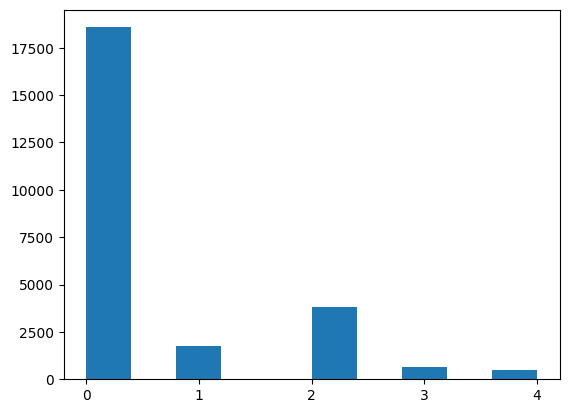

In [ ]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [12]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([ 0.2725,  2.8506,  1.3249,  7.9601, 10.1455], device='cuda:0')


In [ ]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
sample_image = Image.open(sample_image)
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
plt.show()

KeyboardInterrupt: 

In [13]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [14]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [15]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4) #DataLoader for validation_set.
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
from torchvision.models import resnet50,ResNet50_Weights
#Since we've less data, we'll use Transfer learning.
model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50 with 2 new layers.
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.9MB/s]


In [ ]:
model = model.to(device) #Moves the model to the device.

In [ ]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.

        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        # x, y = x.cpu(), y.cpu()
        torch.cuda.empty_cache()

        # Print some information every 10 batches
        if batch % 10 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, './DR_ResNet50.pt')
    return avg_loss, accuracy

In [ ]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [ ]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')



        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Change 5: Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')
            break


        # Step the learning rate scheduler
        scheduler.step()
        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses

In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005)
nb_epochs = 30
patience = 6
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)


Epoch 1/30
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/1583 processed, running loss: 1.642791, correct predictions: 0, total: 16
Batch 10/1583 processed, running loss: 18.061366, correct predictions: 20, total: 176
Batch 20/1583 processed, running loss: 34.284159, correct predictions: 115, total: 336
Batch 30/1583 processed, running loss: 49.992826, correct predictions: 212, total: 496
Batch 40/1583 processed, running loss: 66.044379, correct predictions: 252, total: 656
Batch 50/1583 processed, running loss: 81.977790, correct predictions: 305, total: 816
Batch 60/1583 processed, running loss: 97.340372, correct predictions: 376, total: 976
Batch 70/1583 processed, running loss: 111.831909, correct predictions: 500, total: 1136
Batch 80/1583 processed, running loss: 128.132394, correct predictions: 595, total: 1296
Batch 90/1583 processed, running loss: 143.744915, correct predictions: 698, total: 1456
Batch 100/1583 processed, running loss: 159.618642,

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.657905, correct predictions: 9, total: 16
Batch 10/1583 processed, running loss: 10.840776, correct predictions: 112, total: 176
Batch 20/1583 processed, running loss: 23.189543, correct predictions: 198, total: 336
Batch 30/1583 processed, running loss: 34.359543, correct predictions: 292, total: 496
Batch 40/1583 processed, running loss: 45.876104, correct predictions: 401, total: 656
Batch 50/1583 processed, running loss: 58.009153, correct predictions: 494, total: 816
Batch 60/1583 processed, running loss: 68.518908, correct predictions: 591, total: 976
Batch 70/1583 processed, running loss: 79.806683, correct predictions: 685, total: 1136
Batch 80/1583 processed, running loss: 91.060184, correct predictions: 770, total: 1296
Batch 90/1583 processed, running loss: 101.665053, correct predictions: 858, total: 1456
Batch 100/1583 processed, running loss: 113.171650, correct predictions: 966, total: 1616
Batch 110/1583 processed, running loss: 1

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 2.067342, correct predictions: 11, total: 16
Batch 10/1583 processed, running loss: 12.187900, correct predictions: 116, total: 176
Batch 20/1583 processed, running loss: 22.609892, correct predictions: 233, total: 336
Batch 30/1583 processed, running loss: 34.045887, correct predictions: 354, total: 496
Batch 40/1583 processed, running loss: 43.137078, correct predictions: 472, total: 656
Batch 50/1583 processed, running loss: 52.605964, correct predictions: 589, total: 816
Batch 60/1583 processed, running loss: 61.032610, correct predictions: 714, total: 976
Batch 70/1583 processed, running loss: 70.565035, correct predictions: 832, total: 1136
Batch 80/1583 processed, running loss: 79.042812, correct predictions: 958, total: 1296
Batch 90/1583 processed, running loss: 87.232590, correct predictions: 1093, total: 1456
Batch 100/1583 processed, running loss: 96.698353, correct predictions: 1209, total: 1616
Batch 110/1583 processed, running loss: 

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.768942, correct predictions: 14, total: 16
Batch 10/1583 processed, running loss: 10.755578, correct predictions: 129, total: 176
Batch 20/1583 processed, running loss: 21.250722, correct predictions: 243, total: 336
Batch 30/1583 processed, running loss: 30.284439, correct predictions: 363, total: 496
Batch 40/1583 processed, running loss: 38.361496, correct predictions: 481, total: 656
Batch 50/1583 processed, running loss: 45.949482, correct predictions: 609, total: 816
Batch 60/1583 processed, running loss: 53.093271, correct predictions: 738, total: 976
Batch 70/1583 processed, running loss: 62.492937, correct predictions: 854, total: 1136
Batch 80/1583 processed, running loss: 70.235005, correct predictions: 977, total: 1296
Batch 90/1583 processed, running loss: 78.246013, correct predictions: 1092, total: 1456
Batch 100/1583 processed, running loss: 87.376869, correct predictions: 1217, total: 1616
Batch 110/1583 processed, running loss: 

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 1.637402, correct predictions: 10, total: 16
Batch 10/1583 processed, running loss: 9.404937, correct predictions: 118, total: 176
Batch 20/1583 processed, running loss: 17.223672, correct predictions: 238, total: 336
Batch 30/1583 processed, running loss: 25.501959, correct predictions: 357, total: 496
Batch 40/1583 processed, running loss: 33.445681, correct predictions: 466, total: 656
Batch 50/1583 processed, running loss: 40.279143, correct predictions: 578, total: 816
Batch 60/1583 processed, running loss: 47.995715, correct predictions: 686, total: 976
Batch 70/1583 processed, running loss: 56.015311, correct predictions: 801, total: 1136
Batch 80/1583 processed, running loss: 63.824844, correct predictions: 904, total: 1296
Batch 90/1583 processed, running loss: 71.193984, correct predictions: 1023, total: 1456
Batch 100/1583 processed, running loss: 76.922980, correct predictions: 1163, total: 1616
Batch 110/1583 processed, running loss: 8

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.378984, correct predictions: 11, total: 16
Batch 10/1583 processed, running loss: 6.304281, correct predictions: 146, total: 176
Batch 20/1583 processed, running loss: 12.653095, correct predictions: 275, total: 336
Batch 30/1583 processed, running loss: 17.999802, correct predictions: 403, total: 496
Batch 40/1583 processed, running loss: 25.152975, correct predictions: 535, total: 656
Batch 50/1583 processed, running loss: 32.743749, correct predictions: 664, total: 816
Batch 60/1583 processed, running loss: 39.832706, correct predictions: 775, total: 976
Batch 70/1583 processed, running loss: 47.203790, correct predictions: 902, total: 1136
Batch 80/1583 processed, running loss: 54.613447, correct predictions: 1036, total: 1296
Batch 90/1583 processed, running loss: 61.311557, correct predictions: 1167, total: 1456
Batch 100/1583 processed, running loss: 69.097059, correct predictions: 1290, total: 1616
Batch 110/1583 processed, running loss: 

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.530251, correct predictions: 15, total: 16
Batch 10/1583 processed, running loss: 6.591845, correct predictions: 142, total: 176
Batch 20/1583 processed, running loss: 12.053524, correct predictions: 280, total: 336
Batch 30/1583 processed, running loss: 17.527500, correct predictions: 407, total: 496
Batch 40/1583 processed, running loss: 23.596253, correct predictions: 537, total: 656
Batch 50/1583 processed, running loss: 28.358743, correct predictions: 678, total: 816
Batch 60/1583 processed, running loss: 33.517399, correct predictions: 815, total: 976
Batch 70/1583 processed, running loss: 40.638899, correct predictions: 942, total: 1136
Batch 80/1583 processed, running loss: 47.428041, correct predictions: 1074, total: 1296
Batch 90/1583 processed, running loss: 52.119540, correct predictions: 1214, total: 1456
Batch 100/1583 processed, running loss: 59.675892, correct predictions: 1340, total: 1616
Batch 110/1583 processed, running loss: 

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.201548, correct predictions: 16, total: 16
Batch 10/1583 processed, running loss: 6.388894, correct predictions: 141, total: 176
Batch 20/1583 processed, running loss: 12.164087, correct predictions: 274, total: 336
Batch 30/1583 processed, running loss: 17.888700, correct predictions: 404, total: 496
Batch 40/1583 processed, running loss: 23.645268, correct predictions: 538, total: 656
Batch 50/1583 processed, running loss: 28.472539, correct predictions: 676, total: 816
Batch 60/1583 processed, running loss: 33.130411, correct predictions: 815, total: 976
Batch 70/1583 processed, running loss: 39.563095, correct predictions: 952, total: 1136
Batch 80/1583 processed, running loss: 45.010694, correct predictions: 1082, total: 1296
Batch 90/1583 processed, running loss: 49.472130, correct predictions: 1210, total: 1456
Batch 100/1583 processed, running loss: 53.417494, correct predictions: 1344, total: 1616
Batch 110/1583 processed, running loss: 

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.342132, correct predictions: 14, total: 16
Batch 10/1583 processed, running loss: 5.028346, correct predictions: 145, total: 176
Batch 20/1583 processed, running loss: 9.906145, correct predictions: 271, total: 336
Batch 30/1583 processed, running loss: 14.787631, correct predictions: 406, total: 496
Batch 40/1583 processed, running loss: 18.563215, correct predictions: 542, total: 656
Batch 50/1583 processed, running loss: 24.130592, correct predictions: 677, total: 816
Batch 60/1583 processed, running loss: 29.151856, correct predictions: 814, total: 976
Batch 70/1583 processed, running loss: 33.763846, correct predictions: 949, total: 1136
Batch 80/1583 processed, running loss: 37.432492, correct predictions: 1080, total: 1296
Batch 90/1583 processed, running loss: 42.354582, correct predictions: 1212, total: 1456
Batch 100/1583 processed, running loss: 46.428144, correct predictions: 1356, total: 1616
Batch 110/1583 processed, running loss: 4

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.331204, correct predictions: 14, total: 16
Batch 10/1583 processed, running loss: 3.515613, correct predictions: 155, total: 176
Batch 20/1583 processed, running loss: 6.990306, correct predictions: 289, total: 336
Batch 30/1583 processed, running loss: 10.393277, correct predictions: 429, total: 496
Batch 40/1583 processed, running loss: 13.067840, correct predictions: 569, total: 656
Batch 50/1583 processed, running loss: 16.641242, correct predictions: 708, total: 816
Batch 60/1583 processed, running loss: 19.557368, correct predictions: 844, total: 976
Batch 70/1583 processed, running loss: 22.349178, correct predictions: 981, total: 1136
Batch 80/1583 processed, running loss: 25.747526, correct predictions: 1123, total: 1296
Batch 90/1583 processed, running loss: 29.244640, correct predictions: 1262, total: 1456
Batch 100/1583 processed, running loss: 32.805642, correct predictions: 1407, total: 1616
Batch 110/1583 processed, running loss: 3

<ipython-input-18-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/1583 processed, running loss: 0.196713, correct predictions: 15, total: 16
Batch 10/1583 processed, running loss: 2.761672, correct predictions: 156, total: 176
Batch 20/1583 processed, running loss: 5.715711, correct predictions: 294, total: 336
Batch 30/1583 processed, running loss: 9.020679, correct predictions: 436, total: 496
Batch 40/1583 processed, running loss: 11.998389, correct predictions: 579, total: 656
Batch 50/1583 processed, running loss: 15.768444, correct predictions: 722, total: 816
Batch 60/1583 processed, running loss: 18.674525, correct predictions: 863, total: 976
Batch 70/1583 processed, running loss: 20.435012, correct predictions: 1012, total: 1136
Batch 80/1583 processed, running loss: 22.476642, correct predictions: 1161, total: 1296
Batch 90/1583 processed, running loss: 24.787988, correct predictions: 1306, total: 1456
Batch 100/1583 processed, running loss: 28.809603, correct predictions: 1448, total: 1616
Batch 110/1583 processed, running loss: 3

In [6]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

/content/gdrive/MyDrive/Kaggle/unzip


In [16]:
model = torch.load("DR_ResNet50.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


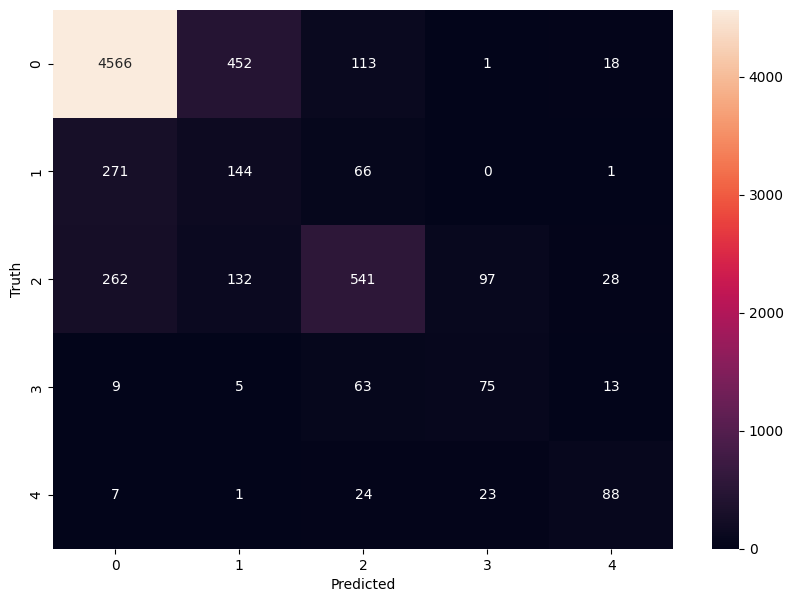

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5150
           1       0.20      0.30      0.24       482
           2       0.67      0.51      0.58      1060
           3       0.38      0.45      0.42       165
           4       0.59      0.62      0.60       143

    accuracy                           0.77      7000
   macro avg       0.55      0.55      0.55      7000
weighted avg       0.79      0.77      0.78      7000

For class 0, Sensitivity: 0.8866019417475728, Specificity: 0.7032432432432433
For class 1, Sensitivity: 0.2987551867219917, Specificity: 0.90948143602332
For class 2, Sensitivity: 0.5103773584905661, Specificity: 0.9552188552188552
For class 3, Sensitivity: 0.45454545454545453, Specificity: 0.9822970007315289
For class 4, Sensitivity: 0.6153846153846154, Specificity: 0.9912498177045355


In [18]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")
